In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [3]:
train_dir = "./dataset/train"
test_dir = "./dataset/test"
val_dir = "./dataset/val"

In [4]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Train set:
------------------------------------------------------------
PNEUMONIA=3876
NORMAL=1342

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=9
NORMAL=9


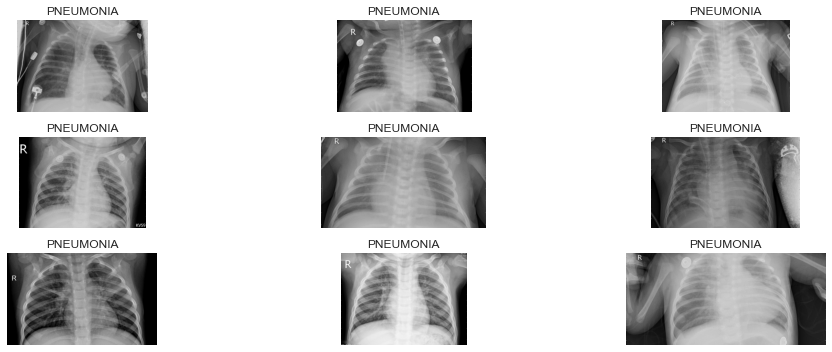

In [5]:
pneumonia = os.listdir("./dataset/train/PNEUMONIA")
pneumonia_dir = "./dataset/train/PNEUMONIA"

plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

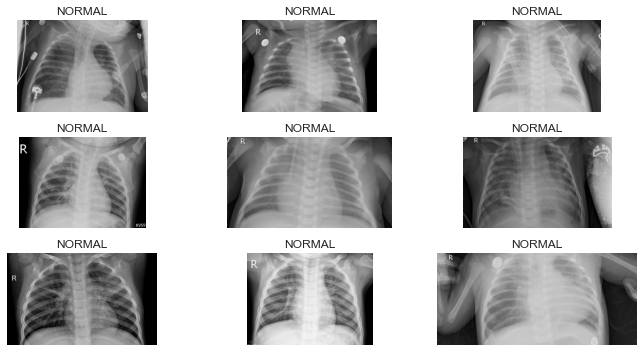

In [6]:
normal = os.listdir("./dataset/train/NORMAL")
normal_dir = "./dataset/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [7]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [8]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

In [9]:
data.head()

,class
0,0
1,0
2,0
3,0
4,0


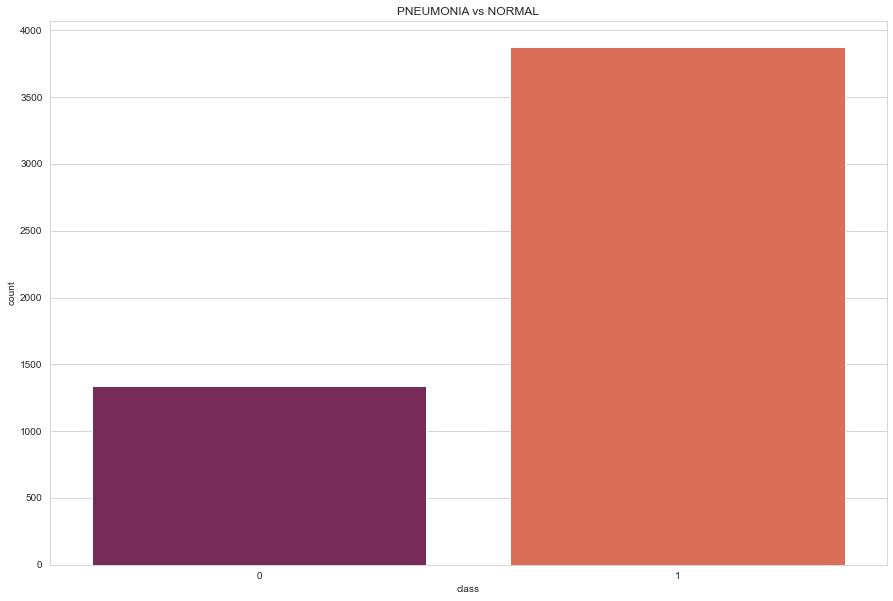

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

In [11]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [13]:

train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


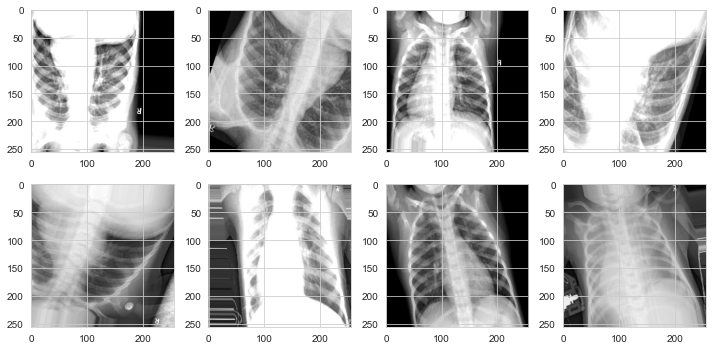

In [25]:
plt.figure(figsize=(10, 5))
for i in range(8):
    img, label = train.next()
    plt.subplot(2, 4, i + 1)
    plt.imshow(img[0])

plt.tight_layout()

In [22]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
history = model2.fit(train,epochs=30, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping, lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 86s 825ms/step - loss: 0.3141 - accuracy: 0.8625 - val_loss: 0.1857 - val_accuracy: 0.9375
Epoch 2/30
100/100 [==============================] - 83s 821ms/step - loss: 0.1899 - accuracy: 0.9187 - val_loss: 0.3292 - val_accuracy: 0.8750
Epoch 3/30
100/100 [==============================] - 81s 809ms/step - loss: 0.2073 - accuracy: 0.9137 - val_loss: 0.1851 - val_accuracy: 0.9375
Epoch 4/30
100/100 [==============================] - 82s 817ms/step - loss: 0.1853 - accuracy: 0.9262 - val_loss: 0.2529 - val_accuracy: 0.8750
Epoch 5/30
100/100 [==============================] - 81s 815ms/step - loss: 0.1707 - accuracy: 0.9291 - val_loss: 0.2155 - val_accuracy: 0.8750
Epoch 6/30
100/100 [==============================] - 80s 804ms/step - loss: 0.1574 - accuracy: 0.9372 - val_loss: 0.2429 - val_accuracy: 0.8125
Epoch 7/30
100/100 [==============================] - 82s 817ms/step - loss: 0.1796 - accuracy: 0.9306 - val_loss: 0.1631 - val_ac

In [25]:
score = model2.evaluate(train)
print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 132s 808ms/step - loss: 0.1173 - accuracy: 0.9555
Train Loss:  0.11729855090379715
Train Accuracy:  0.9555214643478394
312/312 [==============================] - 8s 26ms/step - loss: 0.1998 - accuracy: 0.9199

Test loss:  0.19975192844867706
Test Accuracy:  0.9198718070983887


Text(0.5, 1.0, 'Accuracy Evolution')

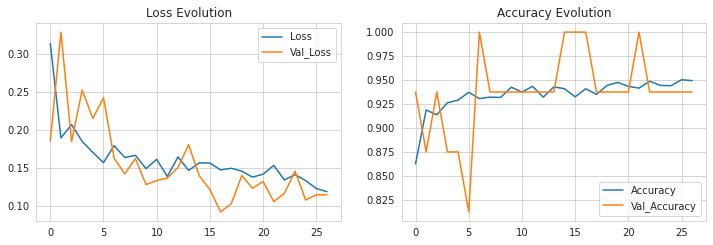

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [27]:
resnet_model.trainable = True

In [28]:
print("Number of layers in the base model: ", len(resnet_model.layers))

fine_tune_at = 100

for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [29]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [31]:
len(model2.trainable_variables)

86

In [33]:
fine_tune_epochs = 10
epochs_on_raw_model = 30
total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model2.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping, lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - 88s 837ms/step - loss: 0.2950 - accuracy: 0.8969 - val_loss: 0.0938 - val_accuracy: 0.9375
Epoch 2/40
100/100 [==============================] - 82s 824ms/step - loss: 0.1690 - accuracy: 0.9372 - val_loss: 25.1485 - val_accuracy: 0.8125
Epoch 3/40
100/100 [==============================] - 82s 822ms/step - loss: 0.1674 - accuracy: 0.9419 - val_loss: 1.6821 - val_accuracy: 0.6875
Epoch 4/40
100/100 [==============================] - 83s 832ms/step - loss: 0.1563 - accuracy: 0.9431 - val_loss: 0.1472 - val_accuracy: 0.9375
Epoch 5/40
100/100 [==============================] - 83s 828ms/step - loss: 0.1413 - accuracy: 0.9466 - val_loss: 5.4022 - val_accuracy: 0.6250
Epoch 6/40
100/100 [==============================] - 83s 832ms/step - loss: 0.1386 - accuracy: 0.9422 - val_loss: 1.0553 - val_accuracy: 0.6875
Epoch 7/40
100/100 [==============================] - 84s 839ms/step - loss: 0.1482 - accuracy: 0.9425 - val_loss: 1.9636 - val_a

In [35]:
score = model2.evaluate(train)
print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 126s 776ms/step - loss: 0.0655 - accuracy: 0.9780
Train Loss:  0.06547978520393372
Train Accuracy:  0.9779524803161621
312/312 [==============================] - 8s 26ms/step - loss: 0.1631 - accuracy: 0.9439

Test loss:  0.16307932138442993
Test Accuracy:  0.9439102411270142


Text(0.5, 1.0, 'Accuracy Evolution')

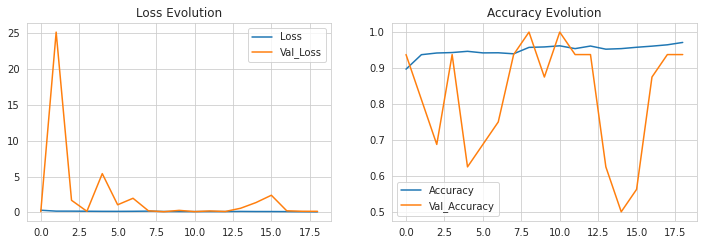

In [42]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')